In [1]:
import pandas as pd
import operator
import numpy as np
import scipy.stats as sps

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib as mpl
mpl.use('TkAgg')

import emcee
import pymc3 as pm

from astropy.table import Table
import astropy.io as asio
from astropy.io import fits
import corner

import io
from google.colab import files

import matplotlib.gridspec as gridspec

%matplotlib inline

def nanmask(array):
    mask = (np.isnan(array) == False)
    newarray = array[mask]
    return newarray, mask

def seanscat(x,y):
    xlab = input("What would you like the x label to be?")
    ylab = input("What would you like the y label to be?")
    pointsize = input("What would you like the size of the scatter points to be?")
    plt.scatter(x,y,s=int(pointsize))
    plt.xlim(0.9*min(x),1.1*max(x))
    plt.ylim(0.9*min(y),1.1*max(y))
    plt.grid()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(xlab+" vs. "+ylab)
    plt.show()
    
def reducer(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)):
        if keycol[i]!=key:
            delindex.append(i)
    return df.drop(delindex)

def reducer2(df,keycol,key=np.inf):
    delindex=[]
    for i in range(len(keycol)): # if key = keycol value
        if keycol[i]==key:
            delindex.append(i)
    return df.drop(delindex)

def reducer3(df,keycol):
    delindex=[]
    for i in range(len(keycol)):
        if np.isnan(keycol[i])==True:
            delindex.append(i)
    return df.drop(delindex)

def residMCMC(sig_y_obs,m,sig_m,x,sig_x,sig_b):
    sig_mx = np.abs(m*x)*np.sqrt((sig_m/m)**2+(sig_x/x)**2)
    sig_mxpb = np.sqrt(sig_mx**2+sig_b**2)
    return np.sqrt((sig_y_obs)**2+(sig_mxpb)**2)

def linfit(m,x,b):
    return m*x+b

def percSplit(splitArr,lowlim=15.87,uplim=84.13): # defaults to 1sigma levels
    upperval = np.percentile(splitArr,uplim)
    lowerval = np.percentile(splitArr,lowlim)
    upperlist,lowerlist = [],[]
    for i in range(len(splitArr)):
        if np.asarray(splitArr)[i]>upperval:
            upperlist.append(i)
        elif np.asarray(splitArr)[i]<lowerval:
            lowerlist.append(i)
    return upperval, lowerval, upperlist,lowerlist

from matplotlib.pyplot import figure
BDecLabel = "$\log$(H\u03B1/H\u03B2)"
LCO10Label = "$\log(L_{CO_{1-0}})$ [K km s$^{-1}$ pc$^2$]"
LCO21Label = "$\log$($L_{CO_{2-1}}$)"
MDustLabel = "$\log$(M$_{Dust})$[M$_\odot$]"
MH2Label = "$\log$($M_{H_2})$[M$_\odot$]"
StarMassLabel = "$\log$(M$_{Star}$) [M$_\odot$]"
SFRLabel = "$\log$(SFR) [$M_\odot$ yr$^{-1}$]"
GasFracLabel = "$\log (f_{H_2})$"
N2HALabel = "$\log$(N$_2$/H\alpha)"

m_MDust = 2.59 # dust
b_MDust = 6.15
m_sd_MDust = .3
b_sd_MDust = .2
f_MDust = 0.28

m_LCO10 = 5.89 # LCO 1-0
b_LCO10 = 4.59
m_sd_LCO10 = .53
b_sd_LCO10 = .33
f_LCO10 = 0.44

m_MH2 = 4.27 # MH2
b_MH2 = 6.29
m_sd_MH2 = .42
b_sd_MH2 = .26
f_MH2 = 0.31

lilPsize = 5
bigPsize = 10

def getMean(x,y,z):
    
    x=np.asarray(x)
    y=np.asarray(y)
    z=np.asarray(z)
    
    minx = 9 # set all these manually
    maxx = 11.5
    miny = -2.5 # should b min(y)
    maxy = 1.75
    points_x = np.linspace(minx,maxx,num=grids)
    points_y = np.linspace(miny,maxx,num=grids)
    gridX,gridY = np.meshgrid(points_x,points_y)
    gridZ = np.zeros([len(gridX),len(gridX)])
    del_x = (maxx-minx)/(2*grids)
    del_y = (maxy-miny)/(2*grids)
    
    for i in range(len(points_x)): # double looping gridX
        for j in range(len(points_y)):
            sumlist=0
            countlist=0
            for g in range(len(x)):
                if x[g]>=(points_x[i]-del_x) and x[g]<=(points_x[i]+del_x) and y[g]>=(points_y[j]-del_y) and y[g]<=(points_y[j]+del_y):
                    sumlist+=z[i]
                    countlist+=1
            if sumlist!=0:
                gridZ[j][i] = sumlist/countlist
    return gridX,gridY,gridZ

/Users/sean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/sean/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/sean/anaconda3/lib/python3.6/s

In [2]:
matchdf = Table.read("CAS-IDs.fits", format='fits').to_pandas()
mpaMaster=pd.read_csv("MPAMaster.csv")
# print(len(mpaMaster),len(matchdf))

del mpaMaster["Unnamed: 0"]

mpaMaster["SPECOBJID"]=matchdf["SPECOBJID"]
mpaMaster["objid"]=matchdf["OBJID"]

In [3]:
mpaMaster.columns.values

# matchdf.columns.values

array(['Z', 'Z err', 'H alpha flux', 'H alpha flux error', 'H beta flux',
       'H beta flux error', 'BDec', 'BDec Err', 'objid', 'expAB_r', 'RA',
       'DEC', 'StarMass', 'StarMass P16', 'StarMass P84', 'SFR',
       'SFR P16', 'SFR P84', 'SFR err', 'SFR FLAG', 'SFR ENTROPY',
       'GALAXY CLASS', '12+LOG OH', '12+LOG OH P16', '12+LOG OH P84',
       '12+LOG OH err', 'EB-V', 'SPECOBJID'], dtype=object)

In [4]:
delindex =[]

for i in range(len(mpaMaster)):
    if mpaMaster["Z"][i]>0.06:
        delindex.append(i)
    elif mpaMaster["Z"][i]<0:
        delindex.append(i)
    elif (mpaMaster["H alpha flux"][i]/mpaMaster["H alpha flux error"][i])<5:
        delindex.append(i)
    elif (mpaMaster["H beta flux"][i]/mpaMaster["H beta flux error"][i])<5:
        delindex.append(i)
    elif mpaMaster["StarMass"][i]<9:
        delindex.append(i)
    elif mpaMaster["GALAXY CLASS"][i]!=1:
        delindex.append(i)
#     elif mpaMaster["SPECOBJID"][i]<100:
#         delindex.append(i)

mpaMaster = mpaMaster.drop(delindex)

In [5]:
mpaMaster["LogBalmerDec"] = np.log10(mpaMaster["H alpha flux"]/mpaMaster["H beta flux"])
mpaMaster["LogBalmerDec Err"] = (np.sqrt((mpaMaster["H alpha flux error"])**2+(mpaMaster["H beta flux error"])**2)*mpaMaster["H beta flux"])/(mpaMaster["H alpha flux"]*np.log(10))

mpaMaster["MH2_MCMC"] = m_MH2*mpaMaster["LogBalmerDec"]+b_MH2
mpaMaster["LCO10_MCMC"] = m_LCO10*mpaMaster["LogBalmerDec"]+b_LCO10

mpaMaster["MDust_MCMC"] = m_MDust*mpaMaster["LogBalmerDec"]+b_MDust

mpaMaster["GasFrac_MCMC"] = np.log10((10**mpaMaster["MH2_MCMC"])/(10**mpaMaster["StarMass"]))

In [6]:
mpaMaster.columns.values

array(['Z', 'Z err', 'H alpha flux', 'H alpha flux error', 'H beta flux',
       'H beta flux error', 'BDec', 'BDec Err', 'objid', 'expAB_r', 'RA',
       'DEC', 'StarMass', 'StarMass P16', 'StarMass P84', 'SFR',
       'SFR P16', 'SFR P84', 'SFR err', 'SFR FLAG', 'SFR ENTROPY',
       'GALAXY CLASS', '12+LOG OH', '12+LOG OH P16', '12+LOG OH P84',
       '12+LOG OH err', 'EB-V', 'SPECOBJID', 'LogBalmerDec',
       'LogBalmerDec Err', 'MH2_MCMC', 'LCO10_MCMC', 'MDust_MCMC',
       'GasFrac_MCMC'], dtype=object)

In [7]:
mpaMaster.to_csv("Sanitycheck.csv",index=False)

mpaMaster=mpaMaster.reset_index()

I went to CASJOBS, retrieved expAB_r's for sources with matching objID's from the "Sanitycheck.csv" - DIDN'T WORK INITIALLY

Now with the SDSS helpdesk trying to fix problem

Fixed! appropriate expAB_r measurement is in objIDs_Seannieboyy.csv file

In [8]:
objIDsdf = pd.read_csv("objIDs_Seannieboyy.csv")
objIDsdf["Incl"]=(180/np.pi)*np.arccos(objIDsdf["expAB_r"])

In [9]:
# print(objIDsdf["dr7objid"])

# objIDsdf.columns.values

# print(mpaMaster["objid"])

mpaMaster["Incl"] = -99.0

tmpList=np.zeros(len(mpaMaster))
tmpList = 99

for i in range(len(mpaMaster)):
    for j in range(len(objIDsdf)):
        if mpaMaster["objid"][i]==objIDsdf["dr7objid"][j]:
            mpaMaster["Incl"][i]=objIDsdf["Incl"][j]
            print("doot"+str(i))
            break

/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


doot0
doot1
doot2
doot3
doot4
doot5
doot6
doot7
doot8
doot9
doot10
doot11
doot12
doot13
doot14
doot15
doot16
doot17
doot18
doot19
doot20
doot21
doot22
doot23
doot24
doot25
doot26
doot27
doot28
doot29
doot30
doot31
doot32
doot33
doot34
doot35
doot36
doot37
doot38
doot39
doot40
doot41
doot42
doot43
doot44
doot45
doot46
doot47
doot48
doot49
doot50
doot51
doot52
doot53
doot54
doot55
doot56
doot57
doot58
doot59
doot60
doot61
doot62
doot63
doot64
doot65
doot66
doot67
doot69
doot70
doot71
doot72
doot73
doot74
doot75
doot76
doot77
doot78
doot79
doot80
doot81
doot82
doot83
doot84
doot85
doot86
doot87
doot88
doot89
doot90
doot91
doot92
doot93
doot94
doot95
doot96
doot97
doot98
doot99
doot100
doot101
doot102
doot103
doot104
doot105
doot106
doot107
doot108
doot109
doot110
doot111
doot112
doot113
doot114
doot115
doot116
doot117
doot118
doot119
doot120
doot121
doot122
doot123
doot124
doot125
doot126
doot127
doot128
doot129
doot130
doot131
doot132
doot133
doot134
doot135
doot136
doot137
doot138
doot1

doot1059
doot1060
doot1061
doot1062
doot1063
doot1064
doot1065
doot1066
doot1067
doot1068
doot1069
doot1070
doot1071
doot1072
doot1073
doot1074
doot1075
doot1076
doot1077
doot1078
doot1079
doot1080
doot1081
doot1082
doot1083
doot1084
doot1085
doot1086
doot1087
doot1088
doot1089
doot1090
doot1091
doot1092
doot1093
doot1094
doot1095
doot1096
doot1097
doot1098
doot1099
doot1100
doot1101
doot1102
doot1103
doot1104
doot1105
doot1106
doot1108
doot1109
doot1110
doot1111
doot1112
doot1113
doot1114
doot1115
doot1116
doot1117
doot1118
doot1119
doot1120
doot1121
doot1122
doot1123
doot1124
doot1125
doot1126
doot1127
doot1128
doot1129
doot1130
doot1131
doot1132
doot1133
doot1134
doot1135
doot1136
doot1138
doot1139
doot1140
doot1141
doot1142
doot1143
doot1144
doot1145
doot1146
doot1147
doot1148
doot1149
doot1150
doot1151
doot1152
doot1153
doot1154
doot1155
doot1156
doot1157
doot1158
doot1159
doot1160
doot1161
doot1162
doot1163
doot1164
doot1165
doot1166
doot1167
doot1168
doot1169
doot1170
doot1171
d

doot2002
doot2003
doot2004
doot2005
doot2006
doot2007
doot2008
doot2009
doot2010
doot2011
doot2012
doot2013
doot2014
doot2015
doot2016
doot2017
doot2018
doot2019
doot2020
doot2021
doot2022
doot2023
doot2024
doot2025
doot2026
doot2027
doot2028
doot2029
doot2030
doot2031
doot2032
doot2033
doot2034
doot2035
doot2036
doot2037
doot2038
doot2039
doot2040
doot2041
doot2042
doot2043
doot2044
doot2045
doot2046
doot2048
doot2049
doot2050
doot2051
doot2052
doot2053
doot2054
doot2055
doot2056
doot2057
doot2058
doot2059
doot2060
doot2061
doot2062
doot2063
doot2064
doot2065
doot2066
doot2067
doot2068
doot2069
doot2070
doot2071
doot2072
doot2073
doot2074
doot2075
doot2076
doot2077
doot2078
doot2079
doot2080
doot2081
doot2082
doot2083
doot2084
doot2085
doot2086
doot2087
doot2088
doot2090
doot2091
doot2092
doot2093
doot2094
doot2095
doot2096
doot2097
doot2098
doot2099
doot2100
doot2101
doot2102
doot2103
doot2104
doot2105
doot2106
doot2107
doot2108
doot2109
doot2110
doot2111
doot2112
doot2113
doot2114
d

doot2939
doot2940
doot2941
doot2942
doot2943
doot2944
doot2945
doot2946
doot2948
doot2949
doot2950
doot2951
doot2952
doot2953
doot2954
doot2955
doot2956
doot2957
doot2958
doot2959
doot2960
doot2961
doot2962
doot2963
doot2964
doot2965
doot2966
doot2967
doot2968
doot2969
doot2970
doot2971
doot2972
doot2973
doot2974
doot2975
doot2976
doot2977
doot2978
doot2979
doot2980
doot2981
doot2982
doot2983
doot2984
doot2985
doot2986
doot2987
doot2988
doot2989
doot2990
doot2991
doot2992
doot2993
doot2994
doot2995
doot2996
doot2997
doot2998
doot2999
doot3000
doot3001
doot3002
doot3003
doot3004
doot3005
doot3006
doot3007
doot3008
doot3009
doot3011
doot3013
doot3014
doot3015
doot3016
doot3017
doot3018
doot3019
doot3020
doot3021
doot3023
doot3024
doot3025
doot3026
doot3027
doot3028
doot3029
doot3030
doot3032
doot3034
doot3035
doot3036
doot3037
doot3038
doot3039
doot3040
doot3041
doot3043
doot3044
doot3045
doot3046
doot3047
doot3048
doot3049
doot3050
doot3052
doot3053
doot3054
doot3055
doot3056
doot3057
d

doot3877
doot3878
doot3879
doot3880
doot3881
doot3882
doot3883
doot3884
doot3885
doot3886
doot3887
doot3888
doot3889
doot3890
doot3891
doot3892
doot3893
doot3894
doot3895
doot3896
doot3897
doot3898
doot3899
doot3900
doot3901
doot3902
doot3903
doot3904
doot3905
doot3906
doot3907
doot3908
doot3909
doot3910
doot3911
doot3912
doot3913
doot3914
doot3915
doot3916
doot3917
doot3918
doot3919
doot3920
doot3921
doot3922
doot3923
doot3924
doot3925
doot3926
doot3927
doot3928
doot3929
doot3930
doot3931
doot3932
doot3933
doot3934
doot3935
doot3936
doot3937
doot3938
doot3939
doot3940
doot3941
doot3942
doot3943
doot3944
doot3945
doot3946
doot3947
doot3948
doot3949
doot3950
doot3951
doot3952
doot3953
doot3954
doot3955
doot3956
doot3957
doot3958
doot3959
doot3960
doot3961
doot3962
doot3963
doot3964
doot3965
doot3966
doot3967
doot3968
doot3969
doot3970
doot3971
doot3972
doot3973
doot3974
doot3975
doot3976
doot3977
doot3978
doot3979
doot3980
doot3981
doot3982
doot3983
doot3984
doot3985
doot3986
doot3987
d

doot4810
doot4811
doot4812
doot4813
doot4814
doot4815
doot4816
doot4817
doot4818
doot4819
doot4820
doot4821
doot4822
doot4823
doot4824
doot4825
doot4826
doot4827
doot4828
doot4829
doot4830
doot4831
doot4832
doot4833
doot4834
doot4835
doot4836
doot4837
doot4838
doot4839
doot4840
doot4841
doot4842
doot4843
doot4844
doot4845
doot4846
doot4847
doot4848
doot4849
doot4850
doot4851
doot4852
doot4853
doot4854
doot4855
doot4856
doot4857
doot4858
doot4859
doot4860
doot4861
doot4862
doot4863
doot4864
doot4865
doot4866
doot4867
doot4868
doot4869
doot4870
doot4871
doot4872
doot4873
doot4874
doot4875
doot4876
doot4877
doot4878
doot4879
doot4880
doot4881
doot4882
doot4883
doot4884
doot4885
doot4886
doot4887
doot4888
doot4889
doot4890
doot4891
doot4892
doot4893
doot4894
doot4895
doot4896
doot4897
doot4898
doot4899
doot4900
doot4901
doot4902
doot4903
doot4904
doot4905
doot4906
doot4907
doot4908
doot4909
doot4910
doot4911
doot4912
doot4913
doot4914
doot4915
doot4916
doot4917
doot4918
doot4919
doot4920
d

doot5737
doot5738
doot5739
doot5740
doot5741
doot5742
doot5743
doot5744
doot5745
doot5746
doot5747
doot5748
doot5749
doot5750
doot5751
doot5752
doot5753
doot5754
doot5755
doot5756
doot5757
doot5758
doot5759
doot5760
doot5761
doot5762
doot5763
doot5764
doot5765
doot5766
doot5767
doot5768
doot5769
doot5770
doot5771
doot5772
doot5773
doot5774
doot5775
doot5776
doot5777
doot5778
doot5779
doot5780
doot5781
doot5782
doot5783
doot5784
doot5785
doot5786
doot5787
doot5788
doot5789
doot5790
doot5791
doot5792
doot5793
doot5794
doot5795
doot5796
doot5798
doot5799
doot5800
doot5801
doot5802
doot5803
doot5804
doot5805
doot5806
doot5807
doot5808
doot5809
doot5810
doot5811
doot5812
doot5813
doot5814
doot5815
doot5816
doot5817
doot5818
doot5819
doot5820
doot5821
doot5822
doot5823
doot5824
doot5825
doot5826
doot5827
doot5828
doot5829
doot5830
doot5831
doot5832
doot5833
doot5834
doot5835
doot5836
doot5837
doot5838
doot5839
doot5840
doot5841
doot5842
doot5843
doot5844
doot5845
doot5846
doot5847
doot5848
d

doot6662
doot6663
doot6664
doot6665
doot6666
doot6667
doot6668
doot6669
doot6670
doot6671
doot6672
doot6673
doot6674
doot6675
doot6676
doot6677
doot6678
doot6679
doot6680
doot6681
doot6682
doot6683
doot6684
doot6685
doot6686
doot6687
doot6688
doot6689
doot6690
doot6691
doot6692
doot6693
doot6694
doot6695
doot6696
doot6697
doot6698
doot6699
doot6700
doot6701
doot6702
doot6703
doot6704
doot6705
doot6706
doot6707
doot6708
doot6709
doot6710
doot6711
doot6712
doot6713
doot6714
doot6715
doot6716
doot6717
doot6718
doot6719
doot6720
doot6721
doot6722
doot6723
doot6724
doot6725
doot6726
doot6727
doot6728
doot6729
doot6730
doot6731
doot6732
doot6733
doot6734
doot6735
doot6736
doot6737
doot6738
doot6739
doot6740
doot6741
doot6742
doot6743
doot6744
doot6745
doot6746
doot6747
doot6748
doot6749
doot6750
doot6751
doot6752
doot6753
doot6754
doot6755
doot6756
doot6757
doot6758
doot6759
doot6760
doot6761
doot6762
doot6763
doot6764
doot6765
doot6766
doot6767
doot6768
doot6769
doot6770
doot6771
doot6772
d

doot7584
doot7585
doot7586
doot7587
doot7588
doot7589
doot7590
doot7591
doot7592
doot7593
doot7594
doot7595
doot7596
doot7597
doot7598
doot7599
doot7600
doot7601
doot7602
doot7603
doot7604
doot7605
doot7606
doot7607
doot7608
doot7609
doot7610
doot7611
doot7612
doot7613
doot7614
doot7615
doot7616
doot7617
doot7618
doot7619
doot7620
doot7621
doot7622
doot7623
doot7624
doot7625
doot7626
doot7627
doot7628
doot7629
doot7630
doot7631
doot7632
doot7633
doot7634
doot7635
doot7636
doot7637
doot7638
doot7639
doot7640
doot7641
doot7642
doot7643
doot7644
doot7645
doot7646
doot7647
doot7648
doot7649
doot7650
doot7651
doot7652
doot7653
doot7655
doot7656
doot7657
doot7658
doot7659
doot7660
doot7661
doot7662
doot7663
doot7664
doot7665
doot7666
doot7667
doot7668
doot7669
doot7670
doot7671
doot7672
doot7673
doot7674
doot7675
doot7676
doot7677
doot7678
doot7679
doot7680
doot7681
doot7682
doot7683
doot7684
doot7685
doot7686
doot7687
doot7688
doot7689
doot7690
doot7691
doot7692
doot7693
doot7694
doot7695
d

doot8508
doot8509
doot8510
doot8511
doot8512
doot8513
doot8514
doot8515
doot8516
doot8517
doot8518
doot8519
doot8520
doot8521
doot8522
doot8523
doot8524
doot8525
doot8526
doot8527
doot8528
doot8529
doot8530
doot8532
doot8533
doot8534
doot8535
doot8537
doot8538
doot8539
doot8540
doot8541
doot8542
doot8543
doot8544
doot8545
doot8546
doot8547
doot8548
doot8549
doot8551
doot8552
doot8553
doot8554
doot8555
doot8556
doot8557
doot8558
doot8559
doot8560
doot8561
doot8562
doot8563
doot8564
doot8565
doot8566
doot8567
doot8568
doot8569
doot8570
doot8571
doot8572
doot8573
doot8574
doot8575
doot8576
doot8577
doot8578
doot8579
doot8580
doot8581
doot8582
doot8583
doot8584
doot8585
doot8586
doot8587
doot8588
doot8589
doot8590
doot8591
doot8592
doot8593
doot8594
doot8595
doot8596
doot8597
doot8598
doot8599
doot8600
doot8601
doot8602
doot8603
doot8604
doot8605
doot8606
doot8607
doot8608
doot8609
doot8610
doot8611
doot8612
doot8613
doot8614
doot8615
doot8616
doot8617
doot8618
doot8619
doot8620
doot8622
d

doot9443
doot9444
doot9445
doot9446
doot9447
doot9448
doot9449
doot9450
doot9451
doot9452
doot9453
doot9454
doot9455
doot9456
doot9457
doot9458
doot9459
doot9460
doot9461
doot9462
doot9463
doot9464
doot9465
doot9466
doot9467
doot9468
doot9469
doot9470
doot9471
doot9472
doot9473
doot9474
doot9475
doot9476
doot9477
doot9478
doot9479
doot9480
doot9481
doot9482
doot9483
doot9484
doot9485
doot9486
doot9488
doot9489
doot9490
doot9491
doot9492
doot9493
doot9494
doot9495
doot9496
doot9497
doot9498
doot9499
doot9500
doot9501
doot9502
doot9503
doot9504
doot9505
doot9506
doot9507
doot9508
doot9509
doot9510
doot9511
doot9512
doot9513
doot9514
doot9515
doot9516
doot9517
doot9518
doot9519
doot9520
doot9521
doot9522
doot9523
doot9524
doot9525
doot9526
doot9527
doot9528
doot9529
doot9530
doot9531
doot9532
doot9533
doot9534
doot9535
doot9536
doot9537
doot9538
doot9539
doot9540
doot9541
doot9542
doot9543
doot9544
doot9545
doot9546
doot9547
doot9548
doot9549
doot9550
doot9551
doot9552
doot9553
doot9554
d

doot10330
doot10331
doot10332
doot10333
doot10334
doot10335
doot10336
doot10337
doot10338
doot10339
doot10340
doot10341
doot10342
doot10343
doot10344
doot10345
doot10346
doot10347
doot10348
doot10349
doot10350
doot10351
doot10352
doot10353
doot10354
doot10355
doot10356
doot10357
doot10358
doot10359
doot10360
doot10361
doot10362
doot10363
doot10364
doot10365
doot10366
doot10367
doot10368
doot10369
doot10370
doot10371
doot10372
doot10373
doot10374
doot10375
doot10376
doot10377
doot10378
doot10379
doot10380
doot10381
doot10382
doot10383
doot10384
doot10385
doot10386
doot10387
doot10388
doot10389
doot10390
doot10391
doot10392
doot10393
doot10394
doot10395
doot10396
doot10397
doot10398
doot10399
doot10400
doot10401
doot10402
doot10403
doot10404
doot10405
doot10406
doot10407
doot10408
doot10409
doot10410
doot10411
doot10412
doot10413
doot10414
doot10415
doot10416
doot10417
doot10418
doot10419
doot10420
doot10421
doot10422
doot10423
doot10424
doot10425
doot10426
doot10427
doot10428
doot10429


doot11179
doot11180
doot11181
doot11182
doot11183
doot11184
doot11185
doot11186
doot11187
doot11188
doot11189
doot11190
doot11191
doot11192
doot11193
doot11194
doot11195
doot11196
doot11197
doot11198
doot11199
doot11200
doot11201
doot11202
doot11203
doot11204
doot11205
doot11206
doot11207
doot11208
doot11209
doot11210
doot11211
doot11212
doot11213
doot11214
doot11215
doot11216
doot11217
doot11218
doot11219
doot11220
doot11221
doot11222
doot11223
doot11224
doot11225
doot11226
doot11227
doot11228
doot11229
doot11230
doot11231
doot11232
doot11233
doot11234
doot11235
doot11236
doot11237
doot11238
doot11239
doot11240
doot11241
doot11242
doot11243
doot11244
doot11245
doot11246
doot11247
doot11248
doot11249
doot11250
doot11251
doot11252
doot11253
doot11254
doot11255
doot11256
doot11257
doot11258
doot11259
doot11260
doot11261
doot11262
doot11263
doot11264
doot11265
doot11266
doot11267
doot11268
doot11269
doot11270
doot11271
doot11272
doot11273
doot11274
doot11275
doot11277
doot11278
doot11279


doot12020
doot12021
doot12022
doot12023
doot12024
doot12025
doot12026
doot12027
doot12028
doot12029
doot12030
doot12031
doot12032
doot12033
doot12034
doot12035
doot12036
doot12037
doot12038
doot12039
doot12040
doot12041
doot12042
doot12043
doot12044
doot12045
doot12046
doot12047
doot12048
doot12049
doot12050
doot12051
doot12052
doot12053
doot12054
doot12055
doot12056
doot12057
doot12058
doot12059
doot12060
doot12061
doot12062
doot12063
doot12064
doot12065
doot12066
doot12067
doot12068
doot12069
doot12070
doot12071
doot12072
doot12073
doot12074
doot12075
doot12076
doot12077
doot12078
doot12079
doot12080
doot12081
doot12082
doot12083
doot12084
doot12085
doot12086
doot12087
doot12088
doot12089
doot12090
doot12091
doot12092
doot12093
doot12094
doot12095
doot12096
doot12097
doot12098
doot12099
doot12100
doot12101
doot12102
doot12103
doot12104
doot12105
doot12106
doot12107
doot12108
doot12109
doot12110
doot12111
doot12112
doot12113
doot12114
doot12115
doot12116
doot12117
doot12118
doot12119


doot12861
doot12862
doot12863
doot12864
doot12865
doot12866
doot12867
doot12868
doot12869
doot12870
doot12871
doot12872
doot12873
doot12874
doot12875
doot12876
doot12877
doot12878
doot12879
doot12880
doot12881
doot12882
doot12883
doot12884
doot12885
doot12886
doot12887
doot12888
doot12889
doot12890
doot12891
doot12892
doot12894
doot12895
doot12896
doot12897
doot12898
doot12899
doot12900
doot12901
doot12902
doot12903
doot12904
doot12905
doot12906
doot12907
doot12908
doot12909
doot12910
doot12911
doot12912
doot12913
doot12914
doot12915
doot12916
doot12917
doot12918
doot12919
doot12920
doot12921
doot12922
doot12923
doot12924
doot12925
doot12926
doot12927
doot12928
doot12929
doot12930
doot12931
doot12932
doot12933
doot12934
doot12935
doot12936
doot12937
doot12938
doot12939
doot12940
doot12941
doot12942
doot12943
doot12944
doot12945
doot12946
doot12947
doot12948
doot12949
doot12950
doot12951
doot12952
doot12953
doot12954
doot12956
doot12957
doot12958
doot12959
doot12960
doot12961
doot12962


doot13703
doot13704
doot13705
doot13706
doot13707
doot13708
doot13709
doot13711
doot13712
doot13713
doot13714
doot13715
doot13716
doot13717
doot13718
doot13719
doot13720
doot13721
doot13722
doot13723
doot13724
doot13725
doot13726
doot13727
doot13728
doot13729
doot13730
doot13731
doot13732
doot13733
doot13734
doot13735
doot13736
doot13737
doot13738
doot13739
doot13740
doot13741
doot13742
doot13743
doot13744
doot13745
doot13746
doot13747
doot13748
doot13749
doot13750
doot13751
doot13752
doot13753
doot13754
doot13755
doot13756
doot13757
doot13758
doot13759
doot13761
doot13762
doot13763
doot13764
doot13765
doot13766
doot13767
doot13768
doot13769
doot13770
doot13771
doot13772
doot13773
doot13774
doot13775
doot13776
doot13777
doot13778
doot13779
doot13781
doot13782
doot13783
doot13784
doot13785
doot13786
doot13787
doot13788
doot13789
doot13790
doot13791
doot13792
doot13793
doot13794
doot13795
doot13796
doot13797
doot13798
doot13799
doot13800
doot13801
doot13802
doot13803
doot13804
doot13805


doot14545
doot14546
doot14547
doot14548
doot14549
doot14550
doot14551
doot14552
doot14553
doot14554
doot14555
doot14556
doot14557
doot14558
doot14559
doot14560
doot14561
doot14562
doot14563
doot14564
doot14565
doot14566
doot14567
doot14568
doot14569
doot14570
doot14571
doot14572
doot14573
doot14574
doot14575
doot14576
doot14577
doot14579
doot14580
doot14581
doot14582
doot14583
doot14584
doot14585
doot14586
doot14587
doot14588
doot14589
doot14590
doot14591
doot14592
doot14593
doot14594
doot14595
doot14597
doot14598
doot14599
doot14600
doot14601
doot14602
doot14603
doot14604
doot14605
doot14606
doot14607
doot14608
doot14609
doot14610
doot14611
doot14612
doot14613
doot14614
doot14615
doot14616
doot14617
doot14618
doot14619
doot14620
doot14621
doot14622
doot14623
doot14624
doot14625
doot14626
doot14627
doot14628
doot14629
doot14630
doot14631
doot14632
doot14633
doot14634
doot14635
doot14636
doot14637
doot14638
doot14639
doot14640
doot14641
doot14642
doot14643
doot14644
doot14645
doot14646


doot15381
doot15382
doot15384
doot15385
doot15386
doot15387
doot15388
doot15389
doot15390
doot15391
doot15392
doot15393
doot15394
doot15395
doot15396
doot15397
doot15398
doot15399
doot15400
doot15401
doot15402
doot15403
doot15404
doot15405
doot15406
doot15407
doot15408
doot15409
doot15410
doot15411
doot15412
doot15413
doot15414
doot15415
doot15416
doot15417
doot15418
doot15419
doot15420
doot15421
doot15422
doot15423
doot15424
doot15425
doot15426
doot15427
doot15428
doot15429
doot15430
doot15431
doot15432
doot15433
doot15434
doot15435
doot15436
doot15437
doot15438
doot15439
doot15440
doot15442
doot15443
doot15444
doot15445
doot15446
doot15447
doot15448
doot15449
doot15450
doot15451
doot15452
doot15453
doot15454
doot15455
doot15456
doot15457
doot15458
doot15459
doot15460
doot15461
doot15462
doot15463
doot15464
doot15465
doot15466
doot15467
doot15468
doot15469
doot15470
doot15471
doot15472
doot15473
doot15474
doot15475
doot15476
doot15477
doot15478
doot15479
doot15480
doot15481
doot15482


doot16220
doot16221
doot16222
doot16223
doot16224
doot16225
doot16226
doot16228
doot16229
doot16230
doot16231
doot16232
doot16233
doot16234
doot16235
doot16236
doot16237
doot16238
doot16239
doot16240
doot16241
doot16242
doot16243
doot16244
doot16245
doot16246
doot16247
doot16248
doot16249
doot16250
doot16251
doot16252
doot16253
doot16254
doot16255
doot16256
doot16257
doot16258
doot16259
doot16260
doot16261
doot16262
doot16263
doot16264
doot16265
doot16266
doot16267
doot16268
doot16269
doot16270
doot16271
doot16273
doot16274
doot16275
doot16276
doot16277
doot16278
doot16279
doot16280
doot16281
doot16282
doot16283
doot16284
doot16285
doot16286
doot16287
doot16288
doot16289
doot16290
doot16291
doot16292
doot16293
doot16294
doot16295
doot16296
doot16297
doot16298
doot16299
doot16300
doot16301
doot16302
doot16303
doot16304
doot16305
doot16306
doot16307
doot16308
doot16309
doot16310
doot16311
doot16312
doot16313
doot16314
doot16315
doot16316
doot16317
doot16318
doot16319
doot16320
doot16321


doot17046
doot17047
doot17048
doot17049
doot17050
doot17051
doot17052
doot17053
doot17054
doot17055
doot17057
doot17058
doot17059
doot17060
doot17061
doot17062
doot17063
doot17064
doot17065
doot17066
doot17067
doot17068
doot17069
doot17070
doot17071
doot17072
doot17073
doot17074
doot17075
doot17076
doot17077
doot17078
doot17079
doot17080
doot17081
doot17083
doot17084
doot17085
doot17086
doot17087
doot17088
doot17089
doot17090
doot17091
doot17092
doot17093
doot17094
doot17095
doot17096
doot17097
doot17098
doot17099
doot17100
doot17101
doot17102
doot17103
doot17104
doot17105
doot17106
doot17107
doot17108
doot17109
doot17110
doot17111
doot17112
doot17113
doot17114
doot17115
doot17116
doot17117
doot17118
doot17119
doot17120
doot17121
doot17122
doot17123
doot17124
doot17125
doot17126
doot17127
doot17128
doot17129
doot17130
doot17131
doot17132
doot17133
doot17134
doot17136
doot17137
doot17138
doot17139
doot17140
doot17141
doot17142
doot17143
doot17144
doot17145
doot17146
doot17147
doot17148


doot17876
doot17877
doot17878
doot17879
doot17880
doot17881
doot17882
doot17883
doot17884
doot17885
doot17886
doot17887
doot17888
doot17889
doot17890
doot17891
doot17892
doot17893
doot17894
doot17895
doot17897
doot17898
doot17899
doot17900
doot17901
doot17902
doot17903
doot17904
doot17905
doot17906
doot17907
doot17908
doot17909
doot17910
doot17911
doot17912
doot17913
doot17914
doot17915
doot17916
doot17917
doot17918
doot17919
doot17920
doot17921
doot17922
doot17923
doot17924
doot17925
doot17926
doot17927
doot17928
doot17929
doot17930
doot17931
doot17932
doot17933
doot17934
doot17935
doot17936
doot17937
doot17938
doot17939
doot17940
doot17941
doot17942
doot17943
doot17944
doot17945
doot17946
doot17947
doot17948
doot17949
doot17950
doot17951
doot17952
doot17953
doot17954
doot17955
doot17956
doot17957
doot17958
doot17959
doot17960
doot17961
doot17962
doot17963
doot17964
doot17965
doot17966
doot17967
doot17968
doot17969
doot17970
doot17971
doot17972
doot17973
doot17974
doot17975
doot17976


doot18705
doot18706
doot18707
doot18708
doot18709
doot18710
doot18711
doot18712
doot18713
doot18714
doot18715
doot18716
doot18717
doot18718
doot18719
doot18720
doot18721
doot18722
doot18723
doot18724
doot18725
doot18726
doot18727
doot18728
doot18729
doot18730
doot18731
doot18732
doot18733
doot18734
doot18735
doot18736
doot18737
doot18738
doot18739
doot18740
doot18741
doot18742
doot18743
doot18744
doot18745
doot18746
doot18747
doot18748
doot18749
doot18751
doot18752
doot18753
doot18754
doot18755
doot18756
doot18757
doot18758
doot18759
doot18760
doot18761
doot18762
doot18763
doot18764
doot18765
doot18767
doot18768
doot18769
doot18770
doot18772
doot18773
doot18774
doot18775
doot18776
doot18777
doot18778
doot18779
doot18780
doot18781
doot18782
doot18783
doot18785
doot18786
doot18787
doot18788
doot18789
doot18790
doot18792
doot18793
doot18794
doot18795
doot18796
doot18797
doot18798
doot18799
doot18800
doot18801
doot18802
doot18803
doot18804
doot18805
doot18806
doot18807
doot18808
doot18809


doot19536
doot19537
doot19538
doot19539
doot19540
doot19541
doot19543
doot19544
doot19545
doot19546
doot19547
doot19548
doot19549
doot19550
doot19551
doot19552
doot19553
doot19555
doot19556
doot19557
doot19558
doot19559
doot19560
doot19561
doot19562
doot19563
doot19564
doot19565
doot19566
doot19568
doot19569
doot19570
doot19571
doot19572
doot19573
doot19574
doot19575
doot19576
doot19577
doot19578
doot19579
doot19580
doot19581
doot19582
doot19583
doot19584
doot19585
doot19586
doot19587
doot19588
doot19589
doot19590
doot19591
doot19592
doot19593
doot19594
doot19595
doot19596
doot19597
doot19598
doot19599
doot19600
doot19601
doot19602
doot19603
doot19604
doot19605
doot19606
doot19607
doot19608
doot19609
doot19610
doot19611
doot19612
doot19613
doot19614
doot19615
doot19616
doot19617
doot19618
doot19619
doot19620
doot19621
doot19622
doot19623
doot19624
doot19625
doot19626
doot19627
doot19628
doot19629
doot19630
doot19631
doot19632
doot19633
doot19634
doot19635
doot19636
doot19637
doot19638


doot20369
doot20370
doot20371
doot20372
doot20373
doot20374
doot20375
doot20376
doot20377
doot20378
doot20379
doot20380
doot20381
doot20382
doot20383
doot20384
doot20385
doot20386
doot20387
doot20388
doot20389
doot20390
doot20391
doot20392
doot20393
doot20394
doot20395
doot20396
doot20397
doot20398
doot20399
doot20400
doot20401
doot20402
doot20403
doot20404
doot20406
doot20407
doot20408
doot20409
doot20410
doot20411
doot20412
doot20413
doot20414
doot20415
doot20416
doot20417
doot20418
doot20419
doot20420
doot20421
doot20422
doot20423
doot20424
doot20425
doot20426
doot20427
doot20428
doot20429
doot20430
doot20431
doot20432
doot20433
doot20434
doot20435
doot20436
doot20437
doot20438
doot20439
doot20440
doot20441
doot20442
doot20443
doot20444
doot20445
doot20446
doot20447
doot20448
doot20449
doot20450
doot20451
doot20452
doot20453
doot20455
doot20456
doot20457
doot20458
doot20459
doot20460
doot20461
doot20462
doot20463
doot20464
doot20465
doot20466
doot20467
doot20468
doot20469
doot20470


doot21201
doot21202
doot21203
doot21204
doot21205
doot21207
doot21208
doot21209
doot21210
doot21211
doot21212
doot21213
doot21214
doot21215
doot21216
doot21217
doot21218
doot21219
doot21220
doot21221
doot21222
doot21223
doot21224
doot21225
doot21226
doot21227
doot21228
doot21229
doot21230
doot21231
doot21232
doot21233
doot21234
doot21235
doot21236
doot21237
doot21238
doot21239
doot21240
doot21241
doot21242
doot21243
doot21244
doot21245
doot21246
doot21247
doot21248
doot21249
doot21250
doot21251
doot21252
doot21253
doot21254
doot21255
doot21256
doot21257
doot21258
doot21259
doot21260
doot21261
doot21262
doot21263
doot21264
doot21265
doot21266
doot21267
doot21268
doot21269
doot21270
doot21271
doot21272
doot21273
doot21274
doot21275
doot21276
doot21277
doot21278
doot21279
doot21280
doot21281
doot21282
doot21283
doot21284
doot21285
doot21286
doot21287
doot21288
doot21289
doot21290
doot21291
doot21292
doot21293
doot21294
doot21295
doot21296
doot21297
doot21298
doot21299
doot21300
doot21301


doot22035
doot22036
doot22037
doot22038
doot22039
doot22040
doot22041
doot22042
doot22043
doot22044
doot22045
doot22046
doot22047
doot22048
doot22049
doot22050
doot22051
doot22052
doot22053
doot22054
doot22055
doot22056
doot22057
doot22058
doot22059
doot22060
doot22061
doot22062
doot22063
doot22064
doot22065
doot22066
doot22067
doot22068
doot22069
doot22070
doot22071
doot22072
doot22073
doot22074
doot22075
doot22076
doot22077
doot22078
doot22079
doot22080
doot22081
doot22082
doot22083
doot22084
doot22085
doot22086
doot22087
doot22088
doot22089
doot22091
doot22092
doot22093
doot22094
doot22095
doot22096
doot22097
doot22098
doot22099
doot22100
doot22101
doot22102
doot22103
doot22104
doot22105
doot22106
doot22107
doot22108
doot22109
doot22110
doot22111
doot22112
doot22113
doot22114
doot22115
doot22116
doot22117
doot22118
doot22119
doot22120
doot22121
doot22122
doot22123
doot22124
doot22125
doot22126
doot22127
doot22128
doot22129
doot22130
doot22131
doot22132
doot22133
doot22134
doot22135


doot22866
doot22867
doot22868
doot22869
doot22870
doot22871
doot22872
doot22873
doot22874
doot22875
doot22876
doot22877
doot22878
doot22879
doot22880
doot22881
doot22882
doot22883
doot22884
doot22885
doot22886
doot22887
doot22888
doot22889
doot22890
doot22891
doot22892
doot22893
doot22894
doot22895
doot22896
doot22897
doot22898
doot22899
doot22900
doot22901
doot22902
doot22903
doot22904
doot22905
doot22906
doot22907
doot22908
doot22909
doot22910
doot22911
doot22912
doot22913
doot22914
doot22915
doot22916
doot22917
doot22918
doot22919
doot22920
doot22921
doot22922
doot22923
doot22924
doot22925
doot22926
doot22927
doot22928
doot22929
doot22930
doot22931
doot22932
doot22933
doot22934
doot22935
doot22936
doot22937
doot22938
doot22939
doot22940
doot22941
doot22942
doot22943
doot22944
doot22945
doot22946
doot22947
doot22948
doot22949
doot22950
doot22951
doot22952
doot22953
doot22954
doot22955
doot22956
doot22957
doot22958
doot22959
doot22960
doot22961
doot22962
doot22963
doot22964
doot22965


doot23698
doot23699
doot23700
doot23701
doot23702
doot23703
doot23704
doot23705
doot23706
doot23707
doot23708
doot23709
doot23710
doot23711
doot23712
doot23713
doot23714
doot23715
doot23716
doot23717
doot23718
doot23719
doot23720
doot23721
doot23722
doot23723
doot23724
doot23725
doot23726
doot23727
doot23728
doot23729
doot23730
doot23731
doot23732
doot23733
doot23734
doot23735
doot23736
doot23737
doot23738
doot23739
doot23740
doot23741
doot23742
doot23743
doot23744
doot23745
doot23746
doot23747
doot23748
doot23749
doot23750
doot23751
doot23752
doot23753
doot23754
doot23755
doot23756
doot23757
doot23758
doot23759
doot23760
doot23761
doot23762
doot23763
doot23764
doot23765
doot23766
doot23767
doot23768
doot23769
doot23770
doot23771
doot23772
doot23773
doot23774
doot23775
doot23776
doot23777
doot23778
doot23779
doot23780
doot23781
doot23782
doot23783
doot23784
doot23785
doot23786
doot23787
doot23788
doot23789
doot23790
doot23791
doot23792
doot23793
doot23794
doot23795
doot23796
doot23797


doot24556
doot24557
doot24558
doot24559
doot24560
doot24561
doot24562
doot24563
doot24564
doot24565
doot24566
doot24567
doot24568
doot24569
doot24570
doot24571
doot24572
doot24573
doot24574
doot24575
doot24576
doot24577
doot24578
doot24579
doot24580
doot24581
doot24582
doot24583
doot24584
doot24585
doot24586
doot24587
doot24588
doot24589
doot24590
doot24591
doot24592
doot24593
doot24594
doot24595
doot24596
doot24597
doot24598
doot24599
doot24600
doot24601
doot24602
doot24603
doot24604
doot24605
doot24607
doot24608
doot24609
doot24610
doot24611
doot24612
doot24613
doot24614
doot24615
doot24616
doot24617
doot24618
doot24619
doot24620
doot24621
doot24622
doot24623
doot24624
doot24625
doot24626
doot24627
doot24628
doot24629
doot24630
doot24631
doot24632
doot24633
doot24634
doot24635
doot24636
doot24637
doot24638
doot24639
doot24640
doot24641
doot24642
doot24643
doot24644
doot24645
doot24646
doot24647
doot24648
doot24649
doot24650
doot24651
doot24652
doot24653
doot24654
doot24655
doot24656


doot25392
doot25393
doot25394
doot25395
doot25396
doot25397
doot25398
doot25399
doot25400
doot25401
doot25402
doot25403
doot25404
doot25405
doot25406
doot25407
doot25408
doot25409
doot25410
doot25411
doot25412
doot25413
doot25414
doot25415
doot25416
doot25417
doot25418
doot25419
doot25420
doot25421
doot25422
doot25423
doot25424
doot25425
doot25426
doot25427
doot25428
doot25429
doot25430
doot25431
doot25433
doot25434
doot25435
doot25436
doot25437
doot25438
doot25439
doot25440
doot25441
doot25442
doot25443
doot25444
doot25445
doot25446
doot25447
doot25448
doot25449
doot25450
doot25451
doot25452
doot25453
doot25454
doot25456
doot25457
doot25458
doot25459
doot25460
doot25461
doot25462
doot25463
doot25464
doot25465
doot25466
doot25467
doot25468
doot25469
doot25470
doot25471
doot25472
doot25473
doot25474
doot25475
doot25476
doot25477
doot25478
doot25479
doot25480
doot25481
doot25482
doot25483
doot25484
doot25485
doot25486
doot25487
doot25488
doot25489
doot25490
doot25491
doot25492
doot25493


doot26228
doot26229
doot26230
doot26231
doot26232
doot26233
doot26234
doot26235
doot26236
doot26237
doot26238
doot26239
doot26240
doot26241
doot26242
doot26243
doot26244
doot26245
doot26246
doot26247
doot26248
doot26249
doot26250
doot26251
doot26252
doot26253
doot26254
doot26255
doot26256
doot26257
doot26258
doot26259
doot26260
doot26261
doot26262
doot26263
doot26264
doot26265
doot26266
doot26267
doot26268
doot26269
doot26270
doot26271
doot26273
doot26274
doot26275
doot26276
doot26277
doot26278
doot26279
doot26280
doot26281
doot26282
doot26283
doot26284
doot26285
doot26286
doot26287
doot26288
doot26289
doot26290
doot26291
doot26292
doot26293
doot26294
doot26295
doot26296
doot26297
doot26298
doot26299
doot26300
doot26301
doot26302
doot26303
doot26304
doot26305
doot26306
doot26307
doot26308
doot26309
doot26310
doot26311
doot26312
doot26313
doot26314
doot26315
doot26316
doot26317
doot26318
doot26319
doot26320
doot26321
doot26322
doot26323
doot26324
doot26325
doot26326
doot26327
doot26328


doot27075
doot27076
doot27077
doot27078
doot27079
doot27080
doot27081
doot27082
doot27083
doot27084
doot27085
doot27086
doot27087
doot27088
doot27089
doot27090
doot27091
doot27092
doot27093
doot27094
doot27095
doot27096
doot27097
doot27098
doot27099
doot27100
doot27101
doot27102
doot27103
doot27104
doot27105
doot27106
doot27107
doot27108
doot27109
doot27110
doot27111
doot27112
doot27113
doot27114
doot27115
doot27116
doot27117
doot27118
doot27119
doot27120
doot27121
doot27122
doot27123
doot27124
doot27125
doot27126
doot27127
doot27128
doot27129
doot27130
doot27131
doot27132
doot27133
doot27134
doot27135
doot27136
doot27137
doot27138
doot27139
doot27140
doot27141
doot27142
doot27143
doot27144
doot27145
doot27146
doot27147
doot27148
doot27149
doot27150
doot27151
doot27152
doot27153
doot27154
doot27155
doot27156
doot27157
doot27158
doot27159
doot27160
doot27161
doot27162
doot27163
doot27164
doot27165
doot27166
doot27167
doot27168
doot27169
doot27170
doot27171
doot27172
doot27173
doot27174


doot27913
doot27914
doot27915
doot27916
doot27917
doot27918
doot27919
doot27920
doot27921
doot27922
doot27923
doot27924
doot27925
doot27926
doot27927
doot27928
doot27929
doot27930
doot27931
doot27932
doot27933
doot27934
doot27935
doot27936
doot27937
doot27938
doot27939
doot27940
doot27941
doot27942
doot27943
doot27944
doot27945
doot27946
doot27947
doot27948
doot27949
doot27950
doot27951
doot27952
doot27953
doot27954
doot27955
doot27956
doot27957
doot27958
doot27959
doot27960
doot27961
doot27962
doot27963
doot27964
doot27965
doot27966
doot27967
doot27968
doot27969
doot27970
doot27971
doot27972
doot27973
doot27974
doot27975
doot27976
doot27977
doot27978
doot27979
doot27980
doot27981
doot27982
doot27983
doot27984
doot27985
doot27986
doot27987
doot27988
doot27989
doot27990
doot27991
doot27992
doot27993
doot27994
doot27995
doot27996
doot27997
doot27998
doot27999
doot28001
doot28002
doot28003
doot28004
doot28005
doot28006
doot28007
doot28008
doot28009
doot28010
doot28011
doot28012
doot28013


doot28750
doot28751
doot28752
doot28753
doot28754
doot28755
doot28756
doot28757
doot28758
doot28759
doot28760
doot28761
doot28762
doot28763
doot28764
doot28765
doot28766
doot28767
doot28768
doot28769
doot28770
doot28771
doot28772
doot28773
doot28774
doot28775
doot28776
doot28777
doot28778
doot28779
doot28780
doot28781
doot28782
doot28783
doot28784
doot28785
doot28786
doot28787
doot28788
doot28789
doot28790
doot28791
doot28792
doot28793
doot28794
doot28795
doot28796
doot28797
doot28798
doot28799
doot28800
doot28801
doot28802
doot28803
doot28804
doot28805
doot28806
doot28807
doot28808
doot28809
doot28810
doot28811
doot28812
doot28813
doot28814
doot28815
doot28816
doot28817
doot28818
doot28819
doot28820
doot28821
doot28822
doot28823
doot28824
doot28825
doot28826
doot28827
doot28828
doot28829
doot28830
doot28831
doot28832
doot28833
doot28834
doot28835
doot28836
doot28837
doot28838
doot28839
doot28840
doot28841
doot28842
doot28843
doot28844
doot28845
doot28846
doot28847
doot28848
doot28849


doot29585
doot29586
doot29587
doot29588
doot29589
doot29590
doot29591
doot29592
doot29593
doot29594
doot29595
doot29596
doot29597
doot29598
doot29599
doot29600
doot29601
doot29602
doot29603
doot29604
doot29605
doot29606
doot29607
doot29608
doot29609
doot29610
doot29611
doot29612
doot29613
doot29614
doot29615
doot29616
doot29617
doot29618
doot29619
doot29620
doot29621
doot29622
doot29623
doot29624
doot29625
doot29626
doot29627
doot29628
doot29629
doot29630
doot29631
doot29632
doot29633
doot29634
doot29635
doot29636
doot29637
doot29638
doot29639
doot29640
doot29641
doot29643
doot29644
doot29645
doot29646
doot29647
doot29648
doot29649
doot29650
doot29651
doot29652
doot29653
doot29654
doot29655
doot29656
doot29657
doot29658
doot29659
doot29660
doot29661
doot29662
doot29663
doot29664
doot29665
doot29666
doot29667
doot29668
doot29669
doot29670
doot29672
doot29673
doot29674
doot29675
doot29676
doot29677
doot29678
doot29679
doot29680
doot29681
doot29682
doot29683
doot29684
doot29685
doot29686


doot30427
doot30428
doot30429
doot30430
doot30431
doot30432
doot30433
doot30435
doot30436
doot30437
doot30438
doot30439
doot30440
doot30441
doot30442
doot30443
doot30444
doot30445
doot30446
doot30447
doot30448
doot30449
doot30450
doot30451
doot30452
doot30453
doot30454
doot30455
doot30456
doot30457
doot30458
doot30459
doot30460
doot30461
doot30462
doot30463
doot30464
doot30465
doot30466
doot30467
doot30468
doot30469
doot30470
doot30471
doot30472
doot30473
doot30474
doot30475
doot30476
doot30477
doot30478
doot30479
doot30480
doot30481
doot30482
doot30483
doot30484
doot30485
doot30486
doot30487
doot30488
doot30489
doot30490
doot30491
doot30492
doot30493
doot30494
doot30495
doot30496
doot30497
doot30498
doot30499
doot30500
doot30501
doot30502
doot30503
doot30504
doot30505
doot30506
doot30508
doot30509
doot30510
doot30511
doot30512
doot30513
doot30514
doot30515
doot30516
doot30517
doot30518
doot30519
doot30520
doot30521
doot30522
doot30523
doot30524
doot30525
doot30526
doot30527
doot30528


doot31271
doot31272
doot31273
doot31275
doot31276
doot31277
doot31278
doot31279
doot31280
doot31281
doot31282
doot31283
doot31284
doot31285
doot31286
doot31287
doot31288
doot31289
doot31290
doot31291
doot31292
doot31293
doot31294
doot31295
doot31296
doot31297
doot31298
doot31299
doot31300
doot31301
doot31302
doot31303
doot31304
doot31305
doot31306
doot31307
doot31308
doot31309
doot31310
doot31311
doot31312
doot31313
doot31314
doot31315
doot31316
doot31317
doot31318
doot31319
doot31320
doot31321
doot31322
doot31323
doot31324
doot31325
doot31326
doot31327
doot31328
doot31329
doot31330
doot31331
doot31332
doot31333
doot31334
doot31335
doot31336
doot31337
doot31338
doot31339
doot31340
doot31341
doot31342
doot31343
doot31344
doot31345
doot31346
doot31347
doot31348
doot31349
doot31350
doot31351
doot31352
doot31353
doot31354
doot31355
doot31356
doot31357
doot31358
doot31359
doot31360
doot31361
doot31362
doot31363
doot31365
doot31366
doot31367
doot31368
doot31369
doot31370
doot31371
doot31372


doot32122
doot32123
doot32124
doot32125
doot32126
doot32127
doot32128
doot32129
doot32130
doot32131
doot32132
doot32133
doot32134
doot32135
doot32137
doot32138
doot32139
doot32140
doot32141
doot32142
doot32143
doot32144
doot32145
doot32146
doot32147
doot32148
doot32149
doot32150
doot32151
doot32152
doot32153
doot32154
doot32155
doot32156
doot32157
doot32158
doot32159
doot32161
doot32162
doot32163
doot32164
doot32165
doot32166
doot32167
doot32168
doot32169
doot32170
doot32171
doot32172
doot32174
doot32175
doot32176
doot32177
doot32178
doot32179
doot32180
doot32181
doot32182
doot32183
doot32184
doot32185
doot32186
doot32187
doot32188
doot32189
doot32190
doot32192
doot32193
doot32194
doot32195
doot32196
doot32197
doot32198
doot32199
doot32200
doot32201
doot32202
doot32203
doot32204
doot32205
doot32206
doot32207
doot32208
doot32209
doot32210
doot32211
doot32212
doot32213
doot32215
doot32216
doot32217
doot32218
doot32219
doot32220
doot32221
doot32222
doot32223
doot32224
doot32225
doot32226


doot32951
doot32952
doot32953
doot32954
doot32955
doot32956
doot32957
doot32958
doot32959
doot32960
doot32961
doot32962
doot32963
doot32964
doot32965
doot32966
doot32967
doot32968
doot32969
doot32970
doot32971
doot32972
doot32973
doot32974
doot32975
doot32976
doot32977
doot32978
doot32979
doot32980
doot32981
doot32983
doot32984
doot32985
doot32986
doot32987
doot32988
doot32989
doot32990
doot32991
doot32992
doot32993
doot32994
doot32995
doot32996
doot32997
doot32998
doot32999
doot33000
doot33001
doot33002
doot33003
doot33004
doot33005
doot33006
doot33007
doot33008
doot33009
doot33010
doot33011
doot33012
doot33013
doot33014
doot33015
doot33016
doot33017
doot33018
doot33019
doot33020
doot33021
doot33022
doot33023
doot33024
doot33025
doot33026
doot33027
doot33028
doot33029
doot33030
doot33031
doot33032
doot33033
doot33034
doot33035
doot33036
doot33037
doot33038
doot33039
doot33040
doot33041
doot33042
doot33044
doot33045
doot33046
doot33047
doot33048
doot33049
doot33050
doot33051
doot33052


doot33789
doot33790
doot33791
doot33792
doot33793
doot33794
doot33795
doot33796
doot33797
doot33798
doot33799
doot33800
doot33801
doot33802
doot33803
doot33804
doot33805
doot33806
doot33807
doot33808
doot33809
doot33810
doot33811
doot33812
doot33813
doot33814
doot33815
doot33816
doot33817
doot33818
doot33819
doot33820
doot33821
doot33822
doot33823
doot33824
doot33825
doot33826
doot33827
doot33828
doot33829
doot33830
doot33831
doot33832
doot33833
doot33834
doot33835
doot33836
doot33837
doot33838
doot33839
doot33840
doot33841
doot33842
doot33843
doot33844
doot33845
doot33846
doot33847
doot33848
doot33849
doot33850
doot33851
doot33852
doot33853
doot33854
doot33855
doot33856
doot33857
doot33858
doot33859
doot33860
doot33861
doot33862
doot33863
doot33864
doot33865
doot33866
doot33867
doot33868
doot33869
doot33870
doot33871
doot33872
doot33873
doot33874
doot33875
doot33876
doot33877
doot33878
doot33879
doot33880
doot33881
doot33882
doot33883
doot33884
doot33885
doot33886
doot33887
doot33888


doot34630
doot34631
doot34632
doot34633
doot34634
doot34635
doot34636
doot34637
doot34638
doot34639
doot34640
doot34641
doot34642
doot34643
doot34644
doot34645
doot34646
doot34647
doot34648
doot34649
doot34650
doot34651
doot34652
doot34653
doot34654
doot34655
doot34656
doot34657
doot34658
doot34659
doot34660
doot34661
doot34662
doot34663
doot34664
doot34665
doot34666
doot34667
doot34669
doot34670
doot34671
doot34672
doot34673
doot34674
doot34675
doot34676
doot34677
doot34678
doot34679
doot34680
doot34681
doot34682
doot34683
doot34684
doot34685
doot34686
doot34687
doot34688
doot34689
doot34690
doot34691
doot34692
doot34693
doot34694
doot34695
doot34696
doot34697
doot34698
doot34699
doot34700
doot34701
doot34702
doot34703
doot34704
doot34705
doot34706
doot34707
doot34708
doot34709
doot34710
doot34711
doot34712
doot34713
doot34714
doot34715
doot34716
doot34717
doot34718
doot34719
doot34720
doot34721
doot34722
doot34723
doot34724
doot34725
doot34726
doot34727
doot34728
doot34729
doot34730


doot35459
doot35460
doot35461
doot35462
doot35463
doot35464
doot35465
doot35466
doot35467
doot35468
doot35469
doot35470
doot35471
doot35472
doot35473
doot35474
doot35475
doot35476
doot35477
doot35478
doot35479
doot35480
doot35481
doot35482
doot35483
doot35484
doot35485
doot35486
doot35487
doot35488
doot35489
doot35490
doot35491
doot35492
doot35493
doot35494
doot35495
doot35496
doot35497
doot35498
doot35499
doot35500
doot35501
doot35502
doot35503
doot35504
doot35505
doot35506
doot35507
doot35508
doot35509
doot35510
doot35511
doot35512
doot35513
doot35514
doot35515
doot35516
doot35517
doot35518
doot35519
doot35520
doot35521
doot35522
doot35523
doot35524
doot35525
doot35526
doot35527
doot35528
doot35530
doot35531
doot35532
doot35533
doot35534
doot35535
doot35536
doot35537
doot35538
doot35539
doot35540
doot35541
doot35542
doot35543
doot35544
doot35545
doot35546
doot35547
doot35548
doot35549
doot35550
doot35551
doot35552
doot35553
doot35554
doot35555
doot35556
doot35557
doot35558
doot35559


doot36290
doot36291
doot36292
doot36293
doot36294
doot36295
doot36296
doot36297
doot36298
doot36299
doot36300
doot36301
doot36302
doot36303
doot36304
doot36305
doot36306
doot36307
doot36308
doot36309
doot36310
doot36311
doot36312
doot36313
doot36314
doot36315
doot36316
doot36317
doot36318
doot36319
doot36320
doot36321
doot36322
doot36323
doot36324
doot36325
doot36326
doot36327
doot36328
doot36329
doot36330
doot36331
doot36332
doot36333
doot36334
doot36335
doot36336
doot36338
doot36339
doot36340
doot36341
doot36342
doot36343
doot36344
doot36345
doot36346
doot36347
doot36348
doot36349
doot36350
doot36351
doot36352
doot36353
doot36354
doot36355
doot36356
doot36357
doot36358
doot36359
doot36360
doot36361
doot36362
doot36363
doot36364
doot36365
doot36366
doot36367
doot36368
doot36369
doot36370
doot36371
doot36372
doot36373
doot36374
doot36375
doot36376
doot36377
doot36378
doot36379
doot36380
doot36381
doot36382
doot36383
doot36384
doot36385
doot36386
doot36387
doot36388
doot36389
doot36390


doot37123
doot37124
doot37125
doot37126
doot37127
doot37128
doot37129
doot37130
doot37131
doot37132
doot37133
doot37134
doot37135
doot37136
doot37137
doot37138
doot37139
doot37140
doot37141
doot37142
doot37143
doot37144
doot37145
doot37146
doot37147
doot37148
doot37149
doot37150
doot37151
doot37152
doot37153
doot37154
doot37155
doot37156
doot37157
doot37158
doot37159
doot37160
doot37161
doot37162
doot37163
doot37164
doot37165
doot37166
doot37167
doot37168
doot37169
doot37170
doot37171
doot37172
doot37173
doot37174
doot37175
doot37176
doot37177
doot37178
doot37179
doot37180
doot37181
doot37182
doot37183
doot37184
doot37185
doot37186
doot37187
doot37188
doot37189
doot37190
doot37191
doot37192
doot37193
doot37194
doot37195
doot37196
doot37197
doot37198
doot37199
doot37200
doot37201
doot37202
doot37203
doot37204
doot37205
doot37206
doot37207
doot37208
doot37209
doot37210
doot37211
doot37212
doot37213
doot37215
doot37216
doot37217
doot37218
doot37219
doot37220
doot37221
doot37222
doot37223


doot37965
doot37966
doot37967
doot37968
doot37969
doot37970
doot37971
doot37972
doot37973
doot37974
doot37975
doot37976
doot37977
doot37978
doot37979
doot37981
doot37982
doot37983
doot37984
doot37985
doot37986
doot37987
doot37988
doot37989
doot37990
doot37991
doot37992
doot37993
doot37994
doot37995
doot37996
doot37997
doot37998
doot37999
doot38000
doot38001
doot38002
doot38003
doot38004
doot38005
doot38006
doot38007
doot38008
doot38009
doot38010
doot38011
doot38012
doot38013
doot38014
doot38015
doot38016
doot38017
doot38018
doot38019
doot38020
doot38021
doot38022
doot38023
doot38024
doot38025
doot38026
doot38028
doot38029
doot38030
doot38031
doot38032
doot38034
doot38035
doot38036
doot38037
doot38038
doot38039
doot38040
doot38041
doot38042
doot38043
doot38044
doot38045
doot38046
doot38047
doot38048
doot38049
doot38050
doot38051
doot38052
doot38053
doot38054
doot38055
doot38056
doot38057
doot38058
doot38059
doot38060
doot38061
doot38062
doot38063
doot38064
doot38065
doot38066
doot38067


doot38800
doot38802
doot38803
doot38804
doot38805
doot38806
doot38807
doot38808
doot38809
doot38810
doot38811
doot38812
doot38813
doot38814
doot38815
doot38816
doot38817
doot38818
doot38819
doot38820
doot38821
doot38822
doot38823
doot38824
doot38825
doot38826
doot38827
doot38828
doot38829
doot38830
doot38831
doot38832
doot38833
doot38834
doot38835
doot38836
doot38837
doot38838
doot38839
doot38840
doot38841
doot38842
doot38843
doot38844
doot38845
doot38846
doot38847
doot38848
doot38850
doot38851
doot38853
doot38854
doot38855
doot38856
doot38858
doot38859
doot38860
doot38861
doot38862
doot38863
doot38865
doot38866
doot38867
doot38868
doot38869
doot38870
doot38871
doot38872
doot38873
doot38874
doot38875
doot38876
doot38877
doot38878
doot38879
doot38880
doot38881
doot38882
doot38883
doot38884
doot38885
doot38886
doot38887
doot38888
doot38889
doot38890
doot38891
doot38892
doot38893
doot38894
doot38895
doot38896
doot38897
doot38898
doot38899
doot38900
doot38901
doot38902
doot38903
doot38904


doot39630
doot39631
doot39632
doot39633
doot39634
doot39635
doot39636
doot39637
doot39638
doot39639
doot39640
doot39641
doot39642
doot39643
doot39644
doot39645
doot39646
doot39647
doot39648
doot39649
doot39650
doot39651
doot39652
doot39653
doot39654
doot39655
doot39656
doot39657
doot39658
doot39659
doot39660
doot39661
doot39662
doot39663
doot39664
doot39665
doot39666
doot39667
doot39668
doot39669
doot39670
doot39671
doot39672
doot39673
doot39674
doot39675
doot39676
doot39677
doot39678
doot39679
doot39680
doot39681
doot39682
doot39683
doot39684
doot39685
doot39686
doot39687
doot39688
doot39689
doot39690
doot39691
doot39692
doot39693
doot39694
doot39695
doot39696
doot39697
doot39698
doot39699
doot39700
doot39701
doot39702
doot39703
doot39704
doot39705
doot39706
doot39707
doot39708
doot39709
doot39710
doot39711
doot39712
doot39714
doot39715
doot39716
doot39717
doot39718
doot39719
doot39720
doot39721
doot39722
doot39723
doot39724
doot39725
doot39726
doot39727
doot39728
doot39729
doot39730


doot40462
doot40463
doot40464
doot40465
doot40466
doot40467
doot40468
doot40469
doot40470
doot40471
doot40472
doot40474
doot40475
doot40476
doot40477
doot40478
doot40479
doot40481
doot40482
doot40483
doot40484
doot40485
doot40486
doot40487
doot40488
doot40489
doot40490
doot40491
doot40492
doot40493
doot40494
doot40495
doot40496
doot40497
doot40499
doot40500
doot40501
doot40502
doot40503
doot40504
doot40505
doot40506
doot40507
doot40508
doot40509
doot40510
doot40511
doot40512
doot40513
doot40514
doot40515
doot40516
doot40517
doot40518
doot40519
doot40520
doot40521
doot40522
doot40523
doot40524
doot40525
doot40526
doot40527
doot40528
doot40529
doot40530
doot40531
doot40532
doot40533
doot40534
doot40535
doot40536
doot40537
doot40538
doot40539
doot40540
doot40541
doot40542
doot40543
doot40544
doot40545
doot40546
doot40547
doot40548
doot40549
doot40550
doot40551
doot40552
doot40553
doot40554
doot40555
doot40556
doot40557
doot40558
doot40559
doot40560
doot40561
doot40562
doot40563
doot40564


doot41304
doot41305
doot41306
doot41307
doot41309
doot41310
doot41311
doot41312
doot41313
doot41314
doot41315
doot41316
doot41317
doot41318
doot41319
doot41320
doot41321
doot41322
doot41323
doot41324
doot41325
doot41326
doot41327
doot41328
doot41329
doot41330
doot41331
doot41332
doot41333
doot41334
doot41335
doot41336
doot41337
doot41339
doot41340
doot41341
doot41342
doot41343
doot41344
doot41345
doot41346
doot41347
doot41348
doot41349
doot41350
doot41351
doot41352
doot41353
doot41354
doot41355
doot41356
doot41357
doot41358
doot41359
doot41360
doot41361
doot41362
doot41363
doot41364
doot41365
doot41366
doot41367
doot41368
doot41369
doot41370
doot41371
doot41372
doot41373
doot41374
doot41375
doot41376
doot41377
doot41378
doot41379
doot41380
doot41381
doot41382
doot41383
doot41384
doot41385
doot41386
doot41387
doot41388
doot41389
doot41390
doot41391
doot41392
doot41393
doot41394
doot41395
doot41396
doot41397
doot41398
doot41399
doot41401
doot41402
doot41403
doot41404
doot41405
doot41406


doot42144
doot42145
doot42146
doot42147
doot42148
doot42149
doot42150
doot42151
doot42152
doot42153
doot42154
doot42155
doot42156
doot42157
doot42158
doot42159
doot42160
doot42161
doot42162
doot42163
doot42164
doot42165
doot42166
doot42167
doot42168
doot42169
doot42170
doot42171
doot42172
doot42173
doot42174
doot42175
doot42176
doot42177
doot42178
doot42179
doot42180
doot42181
doot42182
doot42183
doot42184
doot42185
doot42186
doot42187
doot42188
doot42189
doot42190
doot42191
doot42192
doot42193
doot42194
doot42195
doot42196
doot42197
doot42198
doot42199
doot42200
doot42201
doot42202
doot42204
doot42205
doot42207
doot42208
doot42209
doot42210
doot42211
doot42212
doot42213
doot42214
doot42215
doot42216
doot42217
doot42218
doot42219
doot42220
doot42221
doot42222
doot42223
doot42224
doot42225
doot42226
doot42227
doot42228
doot42229
doot42230
doot42231
doot42232
doot42233
doot42234
doot42235
doot42236
doot42237
doot42239
doot42240
doot42241
doot42242
doot42243
doot42244
doot42245
doot42246


doot42973
doot42974
doot42975
doot42977
doot42978
doot42979
doot42980
doot42981
doot42982
doot42983
doot42984
doot42985
doot42986
doot42987
doot42988
doot42989
doot42990
doot42991
doot42992
doot42993
doot42994
doot42995
doot42996
doot42997
doot42998
doot42999
doot43000
doot43001
doot43003
doot43004
doot43005
doot43006
doot43007
doot43008
doot43009
doot43010
doot43011
doot43012
doot43013
doot43014
doot43015
doot43016
doot43017
doot43018
doot43019
doot43020
doot43022
doot43023
doot43024
doot43025
doot43026
doot43027
doot43028
doot43029
doot43030
doot43031
doot43032
doot43033
doot43034
doot43035
doot43036
doot43037
doot43038
doot43039
doot43040
doot43041
doot43042
doot43043
doot43044
doot43045
doot43046
doot43047
doot43048
doot43049
doot43050
doot43051
doot43052
doot43053
doot43054
doot43055
doot43056
doot43057
doot43058
doot43059
doot43060
doot43061
doot43062
doot43063
doot43064
doot43065
doot43066
doot43067
doot43068
doot43069
doot43070
doot43071
doot43072
doot43073
doot43074
doot43075


doot43809
doot43810
doot43811
doot43812
doot43813
doot43814
doot43815
doot43816
doot43817
doot43818
doot43819
doot43820
doot43821
doot43822
doot43823
doot43824
doot43825
doot43826
doot43827
doot43828
doot43829
doot43830
doot43831
doot43832
doot43833
doot43834
doot43835
doot43836
doot43837
doot43838
doot43839
doot43840
doot43841
doot43842
doot43843
doot43844
doot43845
doot43846
doot43847
doot43848
doot43849
doot43850
doot43851
doot43852
doot43853
doot43854
doot43855
doot43856
doot43857
doot43858
doot43859
doot43860
doot43861
doot43862
doot43863
doot43864
doot43865
doot43866
doot43867
doot43868
doot43869
doot43870
doot43871
doot43872
doot43873
doot43874
doot43875
doot43876
doot43877
doot43878
doot43879
doot43880
doot43881
doot43882
doot43883
doot43884
doot43885
doot43886
doot43887
doot43888
doot43889
doot43890
doot43891
doot43892
doot43893
doot43894
doot43895
doot43896
doot43897
doot43898
doot43899
doot43900
doot43901
doot43902
doot43903
doot43904
doot43905
doot43906
doot43907
doot43908


doot44643
doot44644
doot44645
doot44646
doot44647
doot44648
doot44649
doot44650
doot44651
doot44652
doot44653
doot44654
doot44655
doot44656
doot44657
doot44658
doot44659
doot44660
doot44661
doot44662
doot44663
doot44664
doot44665
doot44666
doot44667
doot44668
doot44669
doot44670
doot44671
doot44672
doot44673
doot44674
doot44675
doot44676
doot44677
doot44678
doot44679
doot44680
doot44681
doot44682
doot44683
doot44684
doot44685
doot44686
doot44687
doot44688
doot44689
doot44690
doot44691
doot44692
doot44693
doot44694
doot44695
doot44696
doot44697
doot44698
doot44699
doot44700
doot44702
doot44703
doot44704
doot44705
doot44706
doot44707
doot44708
doot44709
doot44710
doot44711
doot44712
doot44713
doot44714
doot44715
doot44716
doot44717
doot44718
doot44719
doot44721
doot44722
doot44723
doot44724
doot44725
doot44726
doot44727
doot44728
doot44729
doot44730
doot44731
doot44732
doot44733
doot44734
doot44735
doot44736
doot44737
doot44738
doot44739
doot44740
doot44741
doot44742
doot44743
doot44744


doot45478
doot45479
doot45480
doot45481
doot45482
doot45483
doot45484
doot45485
doot45486
doot45487
doot45488
doot45489
doot45490
doot45491
doot45492
doot45493
doot45494
doot45495
doot45496
doot45497
doot45498
doot45499
doot45500
doot45501
doot45502
doot45503
doot45504
doot45505
doot45506
doot45507
doot45508
doot45509
doot45510
doot45511
doot45512
doot45513
doot45514
doot45515
doot45516
doot45517
doot45518
doot45519
doot45520
doot45521
doot45522
doot45523
doot45524
doot45525
doot45526
doot45527
doot45529
doot45530
doot45531
doot45532
doot45533
doot45534
doot45535
doot45536
doot45537
doot45538
doot45539
doot45540
doot45541
doot45542
doot45543
doot45544
doot45545
doot45546
doot45547
doot45548
doot45549
doot45550
doot45551
doot45552
doot45553
doot45554
doot45555
doot45556
doot45557
doot45558
doot45559
doot45560
doot45561
doot45562
doot45563
doot45564
doot45565
doot45567
doot45568
doot45570
doot45571
doot45572
doot45573
doot45574
doot45575
doot45576
doot45577
doot45578
doot45579
doot45580


doot46316
doot46317
doot46318
doot46319
doot46320
doot46321
doot46322
doot46323
doot46324
doot46325
doot46326
doot46327
doot46328
doot46329
doot46330
doot46331
doot46332
doot46333
doot46334
doot46335
doot46336
doot46337
doot46338
doot46339
doot46340
doot46341
doot46342
doot46343
doot46344
doot46345
doot46346
doot46347
doot46348
doot46349
doot46350
doot46351
doot46352
doot46353
doot46354
doot46355
doot46356
doot46357
doot46358
doot46359
doot46360
doot46361
doot46362
doot46363
doot46364
doot46365
doot46366
doot46367
doot46368
doot46369
doot46370
doot46371
doot46372
doot46373
doot46374
doot46375
doot46376
doot46377
doot46378
doot46379
doot46380
doot46381
doot46382
doot46383
doot46384
doot46385
doot46386
doot46387
doot46388
doot46389
doot46390
doot46391
doot46392
doot46393
doot46394
doot46395
doot46396
doot46397
doot46398
doot46399
doot46400
doot46401
doot46402
doot46403
doot46404
doot46405
doot46406
doot46407
doot46408
doot46409
doot46410
doot46412
doot46413
doot46414
doot46415
doot46416


doot47154
doot47155
doot47156
doot47157
doot47158
doot47159
doot47160
doot47161
doot47162
doot47163
doot47164
doot47166
doot47167
doot47168
doot47169
doot47170
doot47171
doot47172
doot47173
doot47174
doot47175
doot47176
doot47177
doot47178
doot47179
doot47180
doot47181
doot47182
doot47183
doot47184
doot47185
doot47186
doot47187
doot47188
doot47189
doot47190
doot47192
doot47193
doot47194
doot47195
doot47196
doot47197
doot47198
doot47199
doot47200
doot47201
doot47202
doot47203
doot47204
doot47205
doot47206
doot47207
doot47208
doot47209
doot47210
doot47211
doot47212
doot47213
doot47214
doot47215
doot47216
doot47217
doot47218
doot47219
doot47220
doot47221
doot47222
doot47223
doot47224
doot47225
doot47226
doot47227
doot47228
doot47229
doot47230
doot47231
doot47232
doot47233
doot47234
doot47235
doot47236
doot47237
doot47238
doot47239
doot47240
doot47241
doot47242
doot47243
doot47244
doot47245
doot47246
doot47247
doot47248
doot47249
doot47250
doot47251
doot47252
doot47253
doot47254
doot47255


doot47997
doot47999
doot48000
doot48001
doot48002
doot48003
doot48004
doot48005
doot48006
doot48007
doot48008
doot48009
doot48010
doot48011
doot48012
doot48013
doot48014
doot48015
doot48016
doot48017
doot48018
doot48019
doot48020
doot48021
doot48022
doot48023
doot48024
doot48025
doot48026
doot48027
doot48028
doot48029
doot48030
doot48031
doot48032
doot48033
doot48034
doot48035
doot48036
doot48037
doot48038
doot48039
doot48040
doot48041
doot48042
doot48043
doot48044
doot48045
doot48046
doot48047
doot48048
doot48049
doot48050
doot48051
doot48052
doot48053
doot48054
doot48055
doot48056
doot48057
doot48058
doot48059
doot48060
doot48061
doot48062
doot48063
doot48064
doot48065
doot48066
doot48067
doot48068
doot48069
doot48070
doot48071
doot48072
doot48073
doot48074
doot48076
doot48079
doot48080
doot48081
doot48082
doot48083
doot48084
doot48085
doot48087
doot48088
doot48089
doot48090
doot48091
doot48092
doot48093
doot48094
doot48095
doot48096
doot48097
doot48098
doot48099
doot48100
doot48101


doot48836
doot48837
doot48838
doot48839
doot48840
doot48841
doot48842
doot48843
doot48844
doot48845
doot48846
doot48847
doot48848
doot48849
doot48850
doot48851
doot48852
doot48853
doot48854
doot48855
doot48856
doot48857
doot48858
doot48859
doot48860
doot48861
doot48862
doot48863
doot48864
doot48865
doot48866
doot48867
doot48868
doot48869
doot48870
doot48871
doot48872
doot48873
doot48874
doot48875
doot48876
doot48877
doot48878
doot48879
doot48880
doot48881
doot48882
doot48883
doot48884
doot48885
doot48886
doot48887
doot48888
doot48889
doot48890
doot48891
doot48892
doot48893
doot48894
doot48895
doot48896
doot48897
doot48898
doot48899
doot48900
doot48901
doot48902
doot48903
doot48904
doot48905
doot48906
doot48907
doot48909
doot48910
doot48911
doot48912
doot48913
doot48914
doot48915
doot48916
doot48917
doot48918
doot48919
doot48920
doot48921
doot48922
doot48923
doot48924
doot48925
doot48926
doot48927
doot48928
doot48929
doot48930
doot48931
doot48932
doot48933
doot48934
doot48935
doot48936


doot49666
doot49667
doot49668
doot49669
doot49670
doot49671
doot49672
doot49673
doot49674
doot49675
doot49676
doot49677
doot49678
doot49679
doot49680
doot49681
doot49682
doot49683
doot49684
doot49685
doot49686
doot49687
doot49688
doot49689
doot49690
doot49691
doot49692
doot49693
doot49694
doot49695
doot49696
doot49697
doot49698
doot49699
doot49700
doot49702
doot49703
doot49704
doot49705
doot49706
doot49707
doot49708
doot49709
doot49710
doot49711
doot49712
doot49713
doot49714
doot49715
doot49716
doot49717
doot49718
doot49719
doot49720
doot49721
doot49722
doot49723
doot49724
doot49725
doot49726
doot49727
doot49728
doot49729
doot49730
doot49731
doot49732
doot49733
doot49734
doot49735
doot49736
doot49737
doot49738
doot49739
doot49740
doot49741
doot49742
doot49743
doot49744
doot49745
doot49746
doot49747
doot49748
doot49749
doot49750
doot49751
doot49752
doot49753
doot49754
doot49755
doot49756
doot49757
doot49758
doot49759
doot49760
doot49761
doot49762
doot49763
doot49764
doot49765
doot49766


doot50500
doot50501
doot50502
doot50503
doot50504
doot50505
doot50506
doot50507
doot50508
doot50509
doot50510
doot50511
doot50512
doot50513
doot50514
doot50515
doot50516
doot50517
doot50518
doot50519
doot50520
doot50521
doot50522
doot50523
doot50524
doot50525
doot50526
doot50527
doot50528
doot50529
doot50531
doot50532
doot50533
doot50534
doot50535
doot50536
doot50537
doot50538
doot50539
doot50540
doot50541
doot50542
doot50543
doot50544
doot50545
doot50547
doot50548
doot50549
doot50550
doot50551
doot50552
doot50553
doot50554
doot50555
doot50556
doot50557
doot50558
doot50559
doot50560
doot50561
doot50562
doot50563
doot50564
doot50565
doot50566
doot50567
doot50568
doot50569
doot50570
doot50571
doot50572
doot50573
doot50574
doot50575
doot50576
doot50577
doot50578
doot50579
doot50580
doot50581
doot50582
doot50583
doot50584
doot50585
doot50586
doot50587
doot50588
doot50589
doot50590
doot50591
doot50592
doot50593
doot50594
doot50595
doot50596
doot50597
doot50598
doot50599
doot50600
doot50601


doot51334
doot51335
doot51336
doot51337
doot51338
doot51339
doot51340
doot51341
doot51342
doot51343
doot51344
doot51345
doot51346
doot51347
doot51348
doot51349
doot51350
doot51351
doot51352
doot51353
doot51354
doot51355
doot51356
doot51357
doot51358
doot51359
doot51360
doot51361
doot51362
doot51363
doot51364
doot51365
doot51366
doot51367
doot51368
doot51369
doot51370
doot51371
doot51372
doot51373
doot51374
doot51375
doot51376
doot51377
doot51378
doot51379
doot51380
doot51381
doot51383
doot51384
doot51385
doot51386
doot51387
doot51388
doot51389
doot51391
doot51392
doot51393
doot51394
doot51395
doot51396
doot51397
doot51398
doot51399
doot51400
doot51401
doot51402
doot51403
doot51404
doot51405
doot51406
doot51407
doot51408
doot51409
doot51410
doot51411
doot51412
doot51413
doot51414
doot51415
doot51416
doot51417
doot51418
doot51419
doot51420
doot51421
doot51422
doot51423
doot51424
doot51425
doot51426
doot51427
doot51428
doot51430
doot51431
doot51432
doot51433
doot51434
doot51435
doot51436


doot52172
doot52173
doot52175
doot52176
doot52177
doot52178
doot52179
doot52180
doot52182
doot52183
doot52184
doot52185
doot52186
doot52187
doot52188
doot52189
doot52190
doot52191
doot52192
doot52193
doot52194
doot52195
doot52196
doot52197
doot52198
doot52199
doot52200
doot52201
doot52202
doot52203
doot52204
doot52205
doot52206
doot52207
doot52208
doot52209
doot52210
doot52211
doot52212
doot52213
doot52214
doot52215
doot52216
doot52217
doot52218
doot52219
doot52220
doot52221
doot52222
doot52223
doot52224
doot52225
doot52226
doot52227
doot52228
doot52229
doot52230
doot52231
doot52232
doot52233
doot52234
doot52235
doot52236
doot52237
doot52238
doot52239
doot52240
doot52241
doot52242
doot52243
doot52244
doot52245
doot52246
doot52247
doot52248
doot52249
doot52250
doot52251
doot52252
doot52253
doot52254
doot52255
doot52256
doot52257
doot52258
doot52259
doot52260
doot52261
doot52262
doot52263
doot52264
doot52265
doot52266
doot52267
doot52268
doot52269
doot52270
doot52271
doot52272
doot52273


doot53005
doot53006
doot53007
doot53008
doot53009
doot53010
doot53011
doot53012
doot53013
doot53014
doot53015
doot53016
doot53017
doot53018
doot53019
doot53020
doot53021
doot53022
doot53023
doot53024
doot53025
doot53026
doot53027
doot53029
doot53030
doot53031
doot53032
doot53033
doot53034
doot53035
doot53036
doot53037
doot53038
doot53039
doot53040
doot53041
doot53042
doot53043
doot53044
doot53045
doot53046
doot53047
doot53048
doot53049
doot53050
doot53051
doot53052
doot53053
doot53054
doot53055
doot53056
doot53057
doot53058
doot53059
doot53060
doot53061
doot53062
doot53063
doot53064
doot53065
doot53066
doot53067
doot53068
doot53069
doot53070
doot53071
doot53072
doot53073
doot53074
doot53075
doot53076
doot53077
doot53078
doot53079
doot53080
doot53081
doot53082
doot53083
doot53084
doot53085
doot53086
doot53087
doot53088
doot53089
doot53090
doot53091
doot53092
doot53093
doot53094
doot53095
doot53096
doot53097
doot53098
doot53099
doot53100
doot53101
doot53102
doot53103
doot53104
doot53105


doot53855
doot53856
doot53857
doot53858
doot53859
doot53860
doot53861
doot53862
doot53863
doot53864
doot53865
doot53866
doot53867
doot53868
doot53869
doot53870
doot53871
doot53872
doot53873
doot53874
doot53875
doot53876
doot53877
doot53878
doot53879
doot53880
doot53881
doot53882
doot53883
doot53884
doot53885
doot53886
doot53887
doot53888
doot53889
doot53890
doot53891
doot53892
doot53893
doot53894
doot53895
doot53896
doot53897
doot53898
doot53899
doot53900
doot53901
doot53902
doot53903
doot53904
doot53905
doot53906
doot53907
doot53908
doot53909
doot53910
doot53911
doot53912
doot53913
doot53914
doot53915
doot53916
doot53917
doot53918
doot53919
doot53920
doot53921
doot53922
doot53923
doot53924
doot53925
doot53926
doot53927
doot53928
doot53929
doot53930
doot53931
doot53932
doot53933
doot53934
doot53935
doot53936
doot53937
doot53938
doot53939
doot53940
doot53941
doot53942
doot53943
doot53944
doot53945
doot53946
doot53947
doot53948
doot53949
doot53950
doot53951
doot53952
doot53953
doot53954


doot54690
doot54691
doot54692
doot54693
doot54694
doot54695
doot54696
doot54697
doot54698
doot54699
doot54700
doot54701
doot54702
doot54703
doot54704
doot54706
doot54707
doot54708
doot54709
doot54710
doot54711
doot54712
doot54713
doot54714
doot54715
doot54716
doot54717
doot54718
doot54719
doot54720
doot54721
doot54722
doot54723
doot54724
doot54725
doot54726
doot54727
doot54728
doot54729
doot54730
doot54731
doot54732
doot54733
doot54734
doot54735
doot54736
doot54737
doot54738
doot54739
doot54740
doot54741
doot54742
doot54743
doot54744
doot54745
doot54746
doot54747
doot54748
doot54749
doot54750
doot54751
doot54752
doot54753
doot54754
doot54755
doot54756
doot54757
doot54758
doot54759
doot54760
doot54761
doot54762
doot54763
doot54764
doot54765
doot54766
doot54767
doot54768
doot54769
doot54770
doot54771
doot54772
doot54773
doot54774
doot54775
doot54776
doot54777
doot54778
doot54779
doot54780
doot54781
doot54782
doot54783
doot54784
doot54785
doot54786
doot54787
doot54788
doot54789
doot54790


doot55525
doot55526
doot55527
doot55528
doot55529
doot55530
doot55531
doot55532
doot55533
doot55534
doot55535
doot55536
doot55537
doot55538
doot55539
doot55540
doot55541
doot55542
doot55543
doot55544
doot55545
doot55546
doot55547
doot55548
doot55549
doot55550
doot55551
doot55552
doot55553
doot55554
doot55555
doot55556
doot55557
doot55558
doot55559
doot55560
doot55561
doot55562
doot55563
doot55564
doot55565
doot55566
doot55567
doot55568
doot55569
doot55570
doot55571
doot55572
doot55573
doot55575
doot55576
doot55577
doot55578
doot55579
doot55580
doot55581
doot55582
doot55583
doot55584
doot55585
doot55586
doot55587
doot55588
doot55589
doot55590
doot55591
doot55592
doot55593
doot55594
doot55595
doot55596
doot55597
doot55598


In [10]:
delindex = []

for i in range(len(mpaMaster)):
    if mpaMaster["Incl"][i]<0:
        delindex.append(i)
mpaMaster=mpaMaster.drop(delindex)

In [11]:
mpaMaster.to_csv("Sanitycheck2.csv",index=False)

# mpaMaster=mpaMaster.reset_index()

In [12]:
mpaMaster = pd.read_csv("Sanitycheck2.csv")

In [13]:
print(mpaMaster["Incl"])

0        62.605768
1        62.789224
2        78.464275
3        58.686535
4        26.267786
5        70.230166
6        77.327022
7        60.756983
8        77.725149
9        47.344919
10       65.555412
11       54.171559
12       67.787702
13       50.044317
14       67.241610
15       73.434152
16       67.595065
17       45.900423
18       46.654750
19       45.424848
20       58.289033
21       59.759834
22       65.097651
23       51.299270
24       55.678465
25       62.605768
26       60.730556
27       54.702403
28       78.464275
29       62.789224
           ...    
54435    30.792043
54436    43.382975
54437    78.911360
54438    19.966741
54439    54.349959
54440    59.585754
54441    52.298287
54442    52.538038
54443    60.371547
54444    69.932686
54445    69.221178
54446    55.552393
54447    46.447962
54448    67.587436
54449    37.738597
54450    69.167277
54451    78.059248
54452    15.616326
54453    59.613568
54454    54.962027
54455    67.561155
54456    57.

In [9]:
upperinc, lowerinc, upperindex_inc,lowerindex_inc = percSplit(mpaMaster["Incl"])

In [10]:
print(upperinc,lowerinc)

73.0 36.0


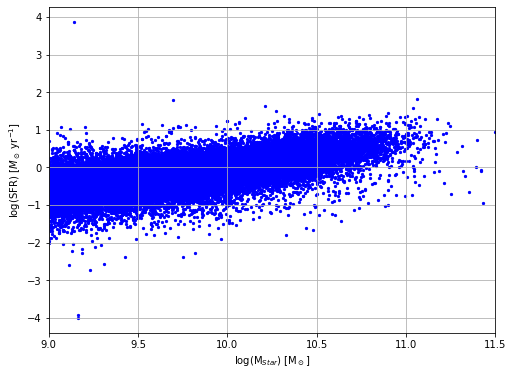

In [6]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c="blue",s=lilPsize)

plt.xlim(9,11.5)
# plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
# plt.text(12,-1,MH2Label,rotation=-90)

plt.savefig("SDSS_fullspread.png",dpi=300)

plt.show()

$M_{H_2}$

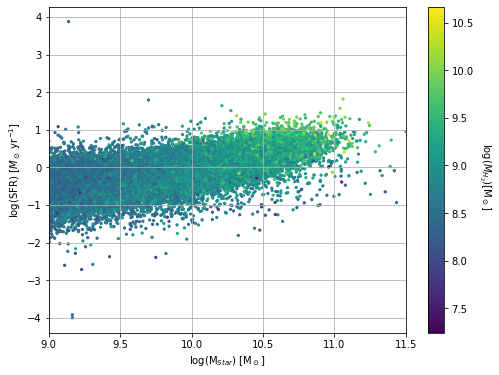

In [260]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["MH2_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,MH2Label,rotation=-90)

plt.savefig("SDSS_MH2.png",dpi=300)

plt.show()

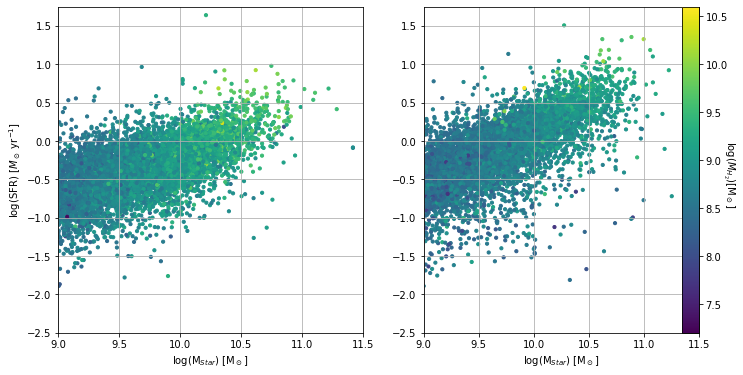

In [290]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["MH2_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,MH2Label,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=7.2,vmax=10.6)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["MH2_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid(True)
# plt.yaxis.set_ticklabels([])
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.7,-.8,MH2Label,rotation=-90)
plt.xlabel(StarMassLabel)

# plt.ylabel(SFRLabel)

plt.clim(vmin=7.2,vmax=10.6)

plt.savefig("SDSS_MH2_InclSplit.png",dpi=300)

plt.show()

Dust

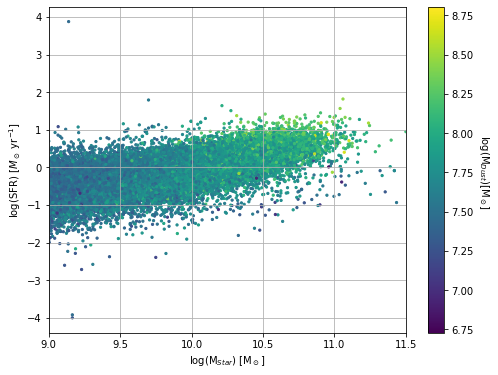

In [295]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["MDust_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,MDustLabel,rotation=-90)

plt.savefig("SDSS_Dust.png",dpi=300)

plt.show()

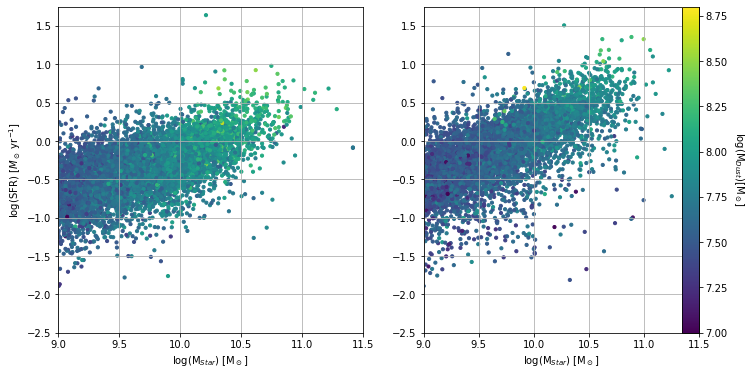

In [293]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["MDust_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,MDustLabel,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=7,vmax=8.8)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["MDust_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid()
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.8,-.8,MDustLabel,rotation=-90)
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.clim(vmin=7,vmax=8.8)

plt.savefig("SDSS_Dust_InclSplit.png",dpi=300)

plt.show()

GasFraction

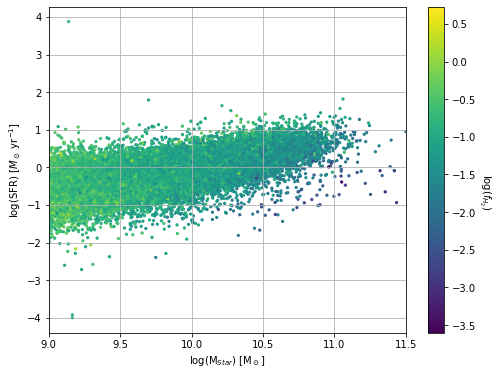

In [17]:
fig=plt.figure(figsize=[8,6])

plt.scatter(mpaMaster["StarMass"],mpaMaster["SFR"],c=mpaMaster["GasFrac_MCMC"],s=lilPsize)

plt.xlim(9,11.5)
plt.colorbar()
plt.ylabel(SFRLabel)
plt.xlabel(StarMassLabel)
plt.grid()
plt.text(12,-1,GasFracLabel,rotation=-90)

plt.savefig("SDSS_GasFrac.png",dpi=300)

plt.show()

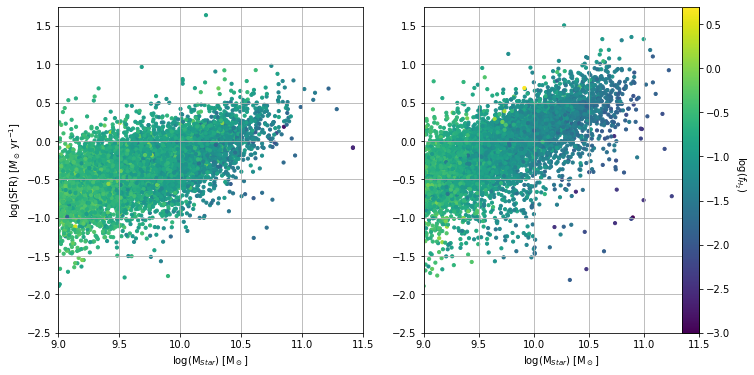

In [16]:
fig = plt.figure(1, figsize=[12,6])

gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))

plt.scatter(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],c=mpaMaster["GasFrac_MCMC"][upperindex_inc],s=bigPsize)
plt.grid()
# plt.colorbar()
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
# plt.text(12.05,-.8,GasFracLabel,rotation=-90)
plt.xlabel(StarMassLabel)
plt.ylabel(SFRLabel)
plt.clim(vmin=-3,vmax=.7)

plt.subplot2grid((1,2), (0,1))

plt.scatter(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],c=mpaMaster["GasFrac_MCMC"][lowerindex_inc],s=bigPsize)
plt.grid()
plt.colorbar(pad=-0.055)
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.text(11.8,-.6,GasFracLabel,rotation=-90)
plt.xlabel(StarMassLabel)
# plt.ylabel(SFRLabel)
plt.clim(vmin=-3,vmax=.7)

plt.savefig("SDSS_GasFrac_InclSplit.png",dpi=300)

plt.show()

In [253]:
grids=100

# tmp = np.asarray(mpaMaster["StarMass"][upperindex_inc])

upperincx,upperincy,upperincz = getMean(mpaMaster["StarMass"][upperindex_inc],mpaMaster["SFR"][upperindex_inc],mpaMaster["GasFrac_MCMC"][upperindex_inc])
lowerincx,lowerincy,lowerincz = getMean(mpaMaster["StarMass"][lowerindex_inc],mpaMaster["SFR"][lowerindex_inc],mpaMaster["GasFrac_MCMC"][lowerindex_inc])


In [254]:
difgrid=upperincz-lowerincz

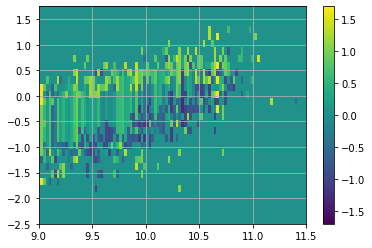

In [257]:
# print(difgrid)

plt.scatter(upperincx,upperincy,c=difgrid,s=50,marker="s")
plt.xlim(9,11.5)
plt.ylim(-2.5,1.75)
plt.colorbar()
plt.clim(-1.7,1.7)
plt.grid()

plt.show()

In [296]:
print(len(mpaMaster))

54465
